In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
#from evaluate import load_metric
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

In [2]:
# Load Dataset
df = pd.read_csv(r"C:\Users\Aakriti K C\Desktop\DA and AI\project 5 amazon sleuth\7817_1.csv")

df.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1597 non-null   object 
 1   asins                 1597 non-null   object 
 2   brand                 1597 non-null   object 
 3   categories            1597 non-null   object 
 4   colors                774 non-null    object 
 5   dateAdded             1597 non-null   object 
 6   dateUpdated           1597 non-null   object 
 7   dimension             565 non-null    object 
 8   ean                   898 non-null    float64
 9   keys                  1597 non-null   object 
 10  manufacturer          965 non-null    object 
 11  manufacturerNumber    902 non-null    object 
 12  name                  1597 non-null   object 
 13  prices                1597 non-null   object 
 14  reviews.date          1217 non-null   object 
 15  reviews.doRecommend  

Now, loading a dataset which contains English parts of speech to see what is the effect of removing adverbs and verbsfrom the Amazon reviews.

In [5]:
# Read the English parts of speech data 
english_adverbs = pd.read_csv(r"C:\Users\Aakriti K C\Desktop\DA and AI\project 5 amazon sleuth\adverbs.csv")
english_verbs = pd.read_csv(r"C:\Users\Aakriti K C\Desktop\DA and AI\project 5 amazon sleuth\verbs.csv")

english_adverbs.head()

,'tween
0,'tween-decks
1,Byronically
2,Christian
3,Christianly
4,Fridays


In [6]:
adverbs_list = english_adverbs["'tween"].tolist()
verbs_list = english_verbs["awake"].tolist()

<Axes: title={'center': 'Amazon Rating Distribution'}, xlabel='Ratings', ylabel='Percentage'>

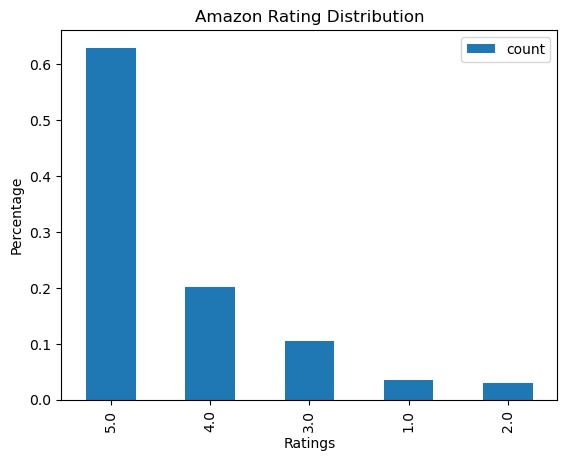

In [7]:
reviews_nan_count = df['reviews.rating'].isna().sum()

file1 = df.groupby('reviews.rating')['reviews.rating'].count().div(len(df)-reviews_nan_count).reset_index(name='count').sort_values(['count'],ascending= False).head(10)

file1.plot(x="reviews.rating",y='count',kind='bar',xlabel='Ratings',ylabel='Percentage',title='Amazon Rating Distribution')

In [8]:
# Map ratings 1 and 2 TO 0 (negative), 3 TO 1 (neutral), 4 and 5 TO 2 (positive) 
sentiment_score = {1: 0,
                   2: 0,
                   3: 1,
                   4: 2,
                   5: 2}

sentiment = {0: 'NEGATIVE',1: 'NEUTRAL',2: 'POSITIVE'}

# Mapping (a 'sentiment' column is added)
df['sentiment_score'] = df['reviews.rating'].map(sentiment_score)
df['sentiment'] = df['sentiment_score'].map(sentiment)

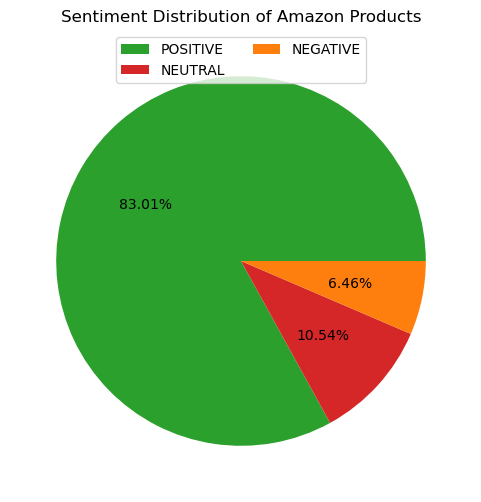

In [9]:
# Plot the distribution of sentiment
plt.figure(figsize = (6,6))

labels = ['POSITIVE','NEUTRAL','NEGATIVE']
cols = ["#2ca02c","#d62728","#ff7f0e"]
plt.pie(df['sentiment'].value_counts(),autopct='%0.2f%%',colors=cols)

plt.title('Distribution of sentiment', size=14, y=-0.01)
plt.legend(labels, ncol=2, loc=9)
plt.title("Sentiment Distribution of Amazon Products")
plt.show()

In [13]:
# Split Data for Training and Testing
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['reviews.text'].tolist(), df['sentiment'].tolist(), test_size=0.2, random_state=42)

In [15]:
# Load Pre-trained LLM (BERT)
model_name = "distilbert-base-uncased"  # Can be changed to BERT, RoBERTa, or GPT
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Convert labels to integers
label_mapping = {"NEGATIVE": 0, "POSITIVE": 1} 
train_labels = [label_mapping.get(label, 0) for label in train_labels] 
val_labels = [label_mapping.get(label, 0) for label in val_labels]

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

# Tokenization
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1277 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

In [19]:
# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

C:\Users\Aakriti K C\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [41]:
# Define Trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    auc = roc_auc_score(labels, predictions) 
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1, "auc": auc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [43]:
# Fine-tune Model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.484600,0.506992,0.718750,0.833333,0.693069,0.756757,0.727891
2,0.407000,0.483164,0.759375,0.869822,0.727723,0.792453,0.770641
3,0.352600,0.491733,0.743750,0.848837,0.722772,0.780749,0.751217


TrainOutput(global_step=240, training_loss=0.46387925148010256, metrics={'train_runtime': 20246.2918, 'train_samples_per_second': 0.189, 'train_steps_per_second': 0.012, 'total_flos': 507482604251136.0, 'train_loss': 0.46387925148010256, 'epoch': 3.0})

In [45]:
# Model Evaluation
trainer.evaluate()

{'eval_loss': 0.48316383361816406,
 'eval_accuracy': 0.759375,
 'eval_precision': 0.8698224852071006,
 'eval_recall': 0.7277227722772277,
 'eval_f1': 0.7924528301886793,
 'eval_auc': 0.7706410471555631,
 'eval_runtime': 272.543,
 'eval_samples_per_second': 1.174,
 'eval_steps_per_second': 0.073,
 'epoch': 3.0}

In [47]:
# Save the Model
trainer.save_model(r"C:\Users\Aakriti K C\Desktop\DA and AI\project 5 amazon sleuth\fine_tuned_model")

In [ ]:
import torch
from transformers import pipeline

# Load fine-tuned model and tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "fine_tuned_distilbert_amazon_reviews"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Define sentiment classification pipeline
def sentiment_classification_pipeline(reviews, batch_size=32):
    """
    Takes raw product reviews and outputs sentiment scores or labels.

    Args:
        reviews (list): List of raw product reviews.
        batch_size (int): Batch size for processing.

    Returns:
        list: Sentiment labels or scores.
    """
    sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
    results = []
    for i in range(0, len(reviews), batch_size):
        batch_reviews = reviews[i:i + batch_size]
        results.extend(sentiment_pipeline(batch_reviews))
    return results


In [ ]:
def aggregate_sentiments(reviews, sentiment_results):
    """
    Aggregate sentiment results for individual products or categories.

    Args:
        reviews (pd.DataFrame): DataFrame with raw reviews and metadata (e.g., product, category, time).
        sentiment_results (list): Sentiment predictions.

    Returns:
        pd.DataFrame: Aggregated sentiment statistics.
    """
    # Add sentiment results to reviews
    reviews['Sentiment'] = [result['label'] for result in sentiment_results]
    reviews['Score'] = [result['score'] for result in sentiment_results]

    # Group and compute summary statistics
    aggregated_data = reviews.groupby(['Product', 'Category', 'TimePeriod']).agg({
        'Sentiment': lambda x: x.value_counts(normalize=True).to_dict(),
        'Score': ['mean', 'std']
    }).reset_index()

    return aggregated_data

# sentiment_results = sentiment_classification_pipeline(reviews_df['ReviewText'].tolist())
# aggregated_results = aggregate_sentiments(reviews_df, sentiment_results)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Visualize sentiment distribution
def plot_sentiment_distribution(reviews):
    """
    Plot sentiment distribution as bar charts or pie charts.

    Args:
        reviews (pd.DataFrame): DataFrame with sentiment predictions.
    """
    sentiment_counts = reviews['Sentiment'].value_counts()
    plt.figure(figsize=(8, 6))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment")
    plt.ylabel("Frequency")
    plt.show()

# Time-series sentiment trend
def plot_sentiment_trends(aggregated_results):
    """
    Plot time-series sentiment trends.

    Args:
        aggregated_results (pd.DataFrame): Aggregated sentiment statistics.
    """
    plt.figure(figsize=(10, 6))
    for sentiment, color in zip(['POSITIVE', 'NEGATIVE', 'NEUTRAL'], ['green', 'red', 'blue']):
        sentiment_trend = aggregated_results.groupby('TimePeriod')['Sentiment'].apply(lambda x: x.get(sentiment, 0))
        plt.plot(sentiment_trend, label=sentiment, color=color)

    plt.title("Sentiment Trends Over Time")
    plt.xlabel("Time Period")
    plt.ylabel("Proportion of Reviews")
    plt.legend()
    plt.show()

# Word clouds for positive/negative reviews
def plot_wordcloud(reviews, sentiment):
    """
    Generate word clouds for frequent terms in positive or negative reviews.

    Args:
        reviews (pd.DataFrame): DataFrame with review text and sentiment.
        sentiment (str): Sentiment to filter reviews (e.g., 'POSITIVE' or 'NEGATIVE').
    """
    text = " ".join(reviews.loc[reviews['Sentiment'] == sentiment, 'ReviewText'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {sentiment} Reviews")
    plt.axis("off")
    plt.show()

# plot_sentiment_distribution(reviews_df)
# plot_sentiment_trends(aggregated_results)
# plot_wordcloud(reviews_df, 'POSITIVE')


In [ ]:
from collections import Counter
import pandas as pd

def analyze_aggregated_results(aggregated_data, reviews):
    """
    Derive actionable insights from aggregated sentiment results and raw reviews.

    Args:
        aggregated_data (pd.DataFrame): Aggregated sentiment statistics.
        reviews (pd.DataFrame): Raw reviews with sentiment predictions.

    Returns:
        dict: Insights categorized by themes (e.g., issues, popular features).
    """
    # Extract frequent terms and themes from positive and negative reviews
    positive_reviews = reviews.loc[reviews['Sentiment'] == 'POSITIVE', 'ReviewText']
    negative_reviews = reviews.loc[reviews['Sentiment'] == 'NEGATIVE', 'ReviewText']

    # Tokenize and count words
    positive_words = Counter(" ".join(positive_reviews).lower().split())
    negative_words = Counter(" ".join(negative_reviews).lower().split())

    # Identify top themes
    positive_themes = positive_words.most_common(10)
    negative_themes = negative_words.most_common(10)

    # Highlight opportunities and concerns
    opportunities = [theme for theme in positive_themes if theme[0] not in negative_words]
    concerns = [theme for theme in negative_themes if theme[0] not in positive_words]

    # Sentiment trends over time
    sentiment_trends = aggregated_data.groupby('TimePeriod')['Sentiment'].apply(lambda x: x.value_counts(normalize=True).to_dict())

    return {
        "Opportunities": opportunities,
        "Concerns": concerns,
        "Sentiment_Trends": sentiment_trends.to_dict()
    }

# insights = analyze_aggregated_results(aggregated_results, reviews_df)

In [ ]:
def generate_actionable_recommendations(insights):
    """
    Generate actionable recommendations based on sentiment insights.

    Args:
        insights (dict): Insights derived from sentiment analysis.

    Returns:
        pd.DataFrame: Business-focused recommendations.
    """
    recommendations = []

    # Address concerns
    for theme, freq in insights['Concerns']:
        recommendations.append({
            "Area": "Improvement",
            "Theme": theme,
            "Frequency": freq,
            "Recommendation": f"Investigate and address the issue related to '{theme}' to improve customer satisfaction."
        })

    # Leverage opportunities
    for theme, freq in insights['Opportunities']:
        recommendations.append({
            "Area": "Engagement",
            "Theme": theme,
            "Frequency": freq,
            "Recommendation": f"Promote and highlight the positive feedback around '{theme}' to attract more customers."
        })

    return pd.DataFrame(recommendations)

# recommendations_df = generate_actionable_recommendations(insights)